In [23]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# num_classes is the number of categories your model chooses between for each prediction
num_classes = 6
resnet_weights_path = '/Users/billyzhaoyh/Desktop/StillGood/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

ResNet_bm = Sequential()
ResNet_bm.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
ResNet_bm.add(Dense(num_classes, activation='sigmoid'))

# The value below is either True or False.  If you choose the wrong answer, your modeling results
# won't be very good.  Recall whether the first layer should be trained/changed or not.
ResNet_bm.layers[0].trainable = True

ResNet_bm.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224

#data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
#use data augmentation techniques
data_generator= ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)


train_generator = data_generator.flow_from_directory(
        '/Users/billyzhaoyh/Desktop/StillGood/Data/Train',
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/Users/billyzhaoyh/Desktop/StillGood/Data/Val',
        class_mode='categorical')

test_generator = data_generator.flow_from_directory(
        '/Users/billyzhaoyh/Desktop/StillGood/Data/Test',
        class_mode='categorical')

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=1),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Found 843 images belonging to 6 classes.
Found 104 images belonging to 6 classes.
Found 108 images belonging to 6 classes.


In [24]:
ResNet_bm.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=callbacks,
        validation_steps=1)

Epoch 1/10
27/27 [==============================] - 629s 23s/step - loss: 0.4075 - acc: 0.8235 - val_loss: 0.3272 - val_acc: 0.8750

In [25]:
ResNet_bm.evaluate_generator(generator=test_generator)

[0.020781642826343025, 0.9953703527097348]

In [26]:
#save the model to json and ship it out
# serialize model to JSON
import os
model_json = ResNet_bm.to_json()
with open("ResNetbm_multi.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ResNet_bm.save_weights("ResNetbm_multi.h5")
print("Saved model to disk")

Saved model to disk


[[0.06336702 0.3707129  0.24741168 0.03700579 0.27422568 0.0072769 ]]
{0: 'Carrot', 1: 'Garlic', 2: 'Lemon', 3: 'Lime', 4: 'Onion', 5: 'Potato'}


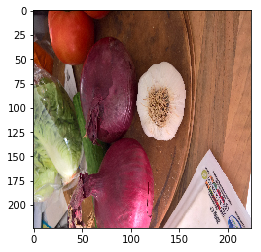

In [27]:
import numpy as np
from keras.preprocessing import image
from matplotlib.pyplot import imshow
%matplotlib inline

img_path = '/Users/billyzhaoyh/Desktop/StillGood/multidata/WP_20190108_12_22_02_Rich.jpg'
img = image.load_img(img_path, target_size=(224, 224))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
pred=ResNet_bm.predict(x)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
a=sum(sum(pred))
print(pred/a)
print(labels)

#seem only working well on Garlic